In [1]:
# @hidden_cell
# The project token is an authorization token that is used to access project ressources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='my_project', project_access_token='my_token')
pc = project.project_context

# Analysis of Conversations

## Prerequisites 
Run the next cell as-is to load the prerequisites from WA-Testing-Tool

In [2]:
!curl -O https://raw.githubusercontent.com/cognitive-catalyst/WA-Testing-Tool/master/log_analytics/extractConversations.py
!curl -O https://raw.githubusercontent.com/cognitive-catalyst/WA-Testing-Tool/master/log_analytics/getAllLogs.py
!curl -O https://raw.githubusercontent.com/cognitive-catalyst/WA-Testing-Tool/master/log_analytics/intent_heatmap.py

%load_ext autoreload
%autoreload 2

!pip install squarify
!pip install ibm-watson

import pandas as pd
import getAllLogs
import extractConversations
import intent_heatmap

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11230  100 11230    0     0  66058      0 --:--:-- --:--:-- --:--:-- 66058
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6318  100  6318    0     0  33786      0 --:--:-- --:--:-- --:--:-- 33606
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3596  100  3596    0     0  19543      0 --:--:-- --:--:-- --:--:-- 19437
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/se

## Configuration and log collection

In [3]:
# API, URL, and workspace ID are extractable from "View API Details page"
iam_apikey="my_iam"
url="my_url"
workspace_id="my_workspace"

#Filter API is described at: https://cloud.ibm.com/docs/assistant?topic=assistant-filter-reference#filter-reference
log_filter="response_timestamp>=2021-03-01,response_timestamp<2021-05-04"

#Change the number of logs retrieved, default settings will return 10,000 logs (20 pages of 500)
page_size_limit=500
page_num_limit=20

#WA API version
version="2018-09-20" 

rawLogsJson = getAllLogs.getLogs(iam_apikey, url, workspace_id, log_filter, page_size_limit, page_num_limit, version)

Fetched 1 log pages


In [5]:
# Define the conversation corrrelation field name for your Watson Assistant records.
# Provide the field name as it appears in the log payload (default is 'response.context.conversation_id')
primaryLogKey = "response.context.conversation_id"

# Name of the correlating key as it appears in the data frame columns (remove 'response.context.')
conversationKey='conversation_id'

# Optionally provide a comma-separated list of custom fields you want to extract, in addition to the default fields
customFieldNames = None

#Extract conversations data and store it at a pandas dataframe
allLogsDF = extractConversations.extractConversationData(rawLogsJson, primaryLogKey, customFieldNames)
conversationsGroup = allLogsDF.groupby(conversationKey,as_index=False)

print("Total log events:",len(allLogsDF))
allLogsDF.head()

Total log events: 241


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,conversation_id,dialog_turn_counter,request_timestamp,response_timestamp,input.text,output.text,nodes_visited,branch_exited_reason,intent,intent_confidence,entities,prev_nodes_visited,conversation_start,message_start,message_end,dialog_turn_number,conversation_length
0,06b95513-a30c-47d6-9671-3915da729cd5,1.0,2021-05-02 19:37:16.313000+00:00,2021-05-02 19:37:16.342000+00:00,,"Hallo. Ich bin Lea und freue mich, von Ihnen z...","(Willkommen,)",completed,,0.000000,,,2021-05-02 19:37:16.313000+00:00,00:00:00,00:00:00,1,10
1,06b95513-a30c-47d6-9671-3915da729cd5,2.0,2021-05-02 19:37:28.957000+00:00,2021-05-02 19:37:28.990000+00:00,test1234567890,,(),fallback,,0.000000,"({'entity': 'Hausnummer', 'location': [4, 7], ...","(Willkommen,)",2021-05-02 19:37:16.313000+00:00,00:00:00.029000,00:00:12.644000,2,10
2,06b95513-a30c-47d6-9671-3915da729cd5,3.0,2021-05-02 19:37:40.185000+00:00,2021-05-02 19:37:40.250000+00:00,hallo?,Wie kann ich Ihnen helfen?,"(node_6_1616420354968,)",completed,General_Greetings,0.847273,,(),2021-05-02 19:37:16.313000+00:00,00:00:12.677000,00:00:23.872000,3,10
3,06b95513-a30c-47d6-9671-3915da729cd5,4.0,2021-05-02 19:37:56.362000+00:00,2021-05-02 19:37:56.424000+00:00,ich möchte meine adresse ändern lassen in ihre...,Dabei kann ich Ihnen gerne helfen! Möchten Sie...,"(node_4_1616254197330,)",,Customer_Care_User_newAddress,0.965179,"({'entity': 'Strasse', 'location': [32, 38], '...","(node_6_1616420354968,)",2021-05-02 19:37:16.313000+00:00,00:00:23.937000,00:00:40.049000,4,10
4,06b95513-a30c-47d6-9671-3915da729cd5,5.0,2021-05-02 19:38:00.968000+00:00,2021-05-02 19:38:00.997000+00:00,ja,Geben Sie bitte Ihre Kundennummer ein!,"(node_10_1617382729227,)",,General_Positive_Feedback,0.907424,"({'entity': 'yes', 'location': [0, 2], 'value'...","(node_4_1616254197330,)",2021-05-02 19:37:16.313000+00:00,00:00:40.111000,00:00:44.655000,5,10


In [ ]:
#save the log-file as a data asset in studio project
project.save_data(file_name = "logs.csv",data = allLogsDF.to_csv(index=False))

In [6]:
df_intents = allLogsDF[["input.text","intent","intent_confidence"]]
df_intents.head()

,input.text,intent,intent_confidence
0,,,0.000000
1,test1234567890,,0.000000
2,hallo?,General_Greetings,0.847273
3,ich möchte meine adresse ändern lassen in ihre...,Customer_Care_User_newAddress,0.965179
4,ja,General_Positive_Feedback,0.907424


In [11]:
df_entities = allLogsDF[["input.text", "entities"]]
df_entities.head()

,input.text,entities
0,,
1,test1234567890,"({'entity': 'Hausnummer', 'location': [4, 7], ..."
2,hallo?,
3,ich möchte meine adresse ändern lassen in ihre...,"({'entity': 'Strasse', 'location': [32, 38], '..."
4,ja,"({'entity': 'yes', 'location': [0, 2], 'value'..."


In [33]:
df_intents = df_intents.assign(classification="")

In [15]:
df_entities = df_entities.assign(classification="NA")

In [ ]:
#save the intent-file as a data asset in studio project
project.save_data(file_name = "intents.csv",data = df_intents.to_csv(index=False))

In [ ]:
#save the entity-file as a data asset in studio project
project.save_data(file_name = "entites.csv",data = df_entities.to_csv(index=False))

# Count unique conversations

In [7]:
print("Total log events:",len(allLogsDF))
print("Total conversations:",len(allLogsDF[conversationKey].unique()))

Total log events: 241
Total conversations: 35


## Number of times a given node is visited

In [9]:
#count visits of "bestätigungsknoten"
node_to_search="node_9_1618232019798"
node_visits_as_frame = allLogsDF[[node_to_search in x for x in allLogsDF['nodes_visited']]]

print("Total visits to target node:",len(node_visits_as_frame))

Total visits to target node: 12


## Number of unique conversations visiting a node

In [12]:
#count the unique conversations visiting "bestätigungsknoten"
print("Unique visitors to target node:",len(node_visits_as_frame[conversationKey].unique()))

Unique visitors to target node: 11


## Gathering initial user responses via hardcoded dialog turn number

In [13]:
#use the `dialog_turn_counter` field to extract utterances on a given turn. 
#user speaks first, search on USER_FIRST_TURN_COUNTER=1
#assistant speaks first, use USER_FIRST_TURN_COUNTER=2
USER_FIRST_TURN_COUNTER=2
userFirstTurnView = allLogsDF[allLogsDF['dialog_turn_counter']==USER_FIRST_TURN_COUNTER]
userFirstTurnDF = userFirstTurnView[["input.text","intent","intent_confidence"]]

len(userFirstTurnDF)
userFirstTurnDF.head()

,input.text,intent,intent_confidence
1,test1234567890,,0.000000
11,servus,General_Ending,1.000000
17,Servus!,General_Ending,1.000000
34,hi,General_Greetings,1.000000
46,hallo.,General_Greetings,0.847273


## Summarizing the response distribution

In [14]:
# Using pandas aggregators to count how often each intent is selected and its average confidence
userIntentSummaryDF = userFirstTurnDF.groupby('intent',as_index=False).agg({
   'input.text': ['count'], 
   'intent_confidence': ['mean']
})

#rename columns
userIntentSummaryDF.columns=["intent","count","confidence"]

# Increases readability of dashboard reports
if userIntentSummaryDF.loc[0,"intent"]=="":
    userIntentSummaryDF.loc[0,"intent"]="(no intent found)"

userIntentSummaryDF.head()

,intent,count,confidence
0,(no intent found),3,0.000000
1,General_Ending,3,0.854945
2,General_Greetings,9,0.902393
3,General_Jokes,1,0.676433


## visualization for the intents in a tree map

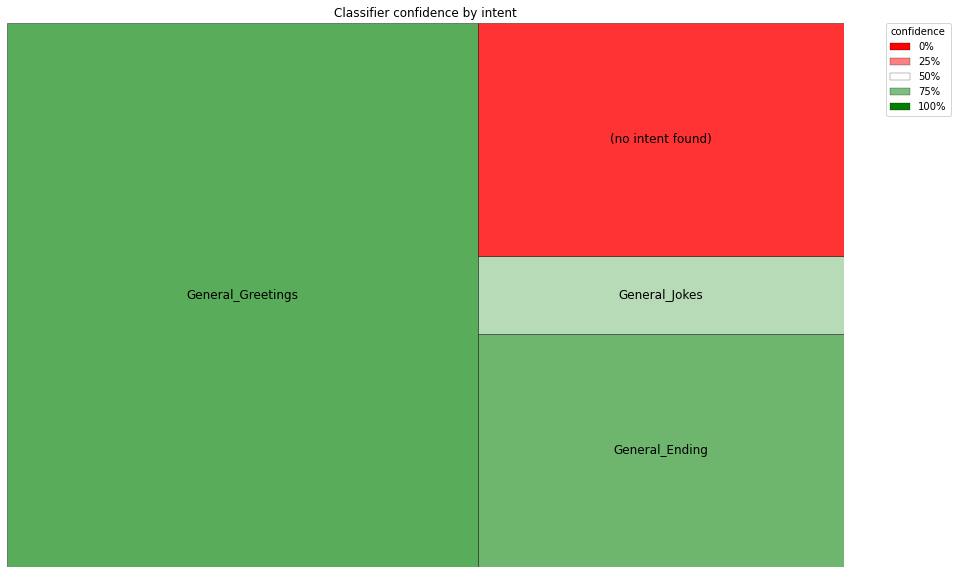

In [15]:
#Tree maps are visualizations, they look at two dimensions at once. 
#One dimension is expressed in size and the other via color and/or placement.
#Number of times intent appears as the size
#Average confidence of intent as color/placement (high confidence as green and lower-left, low confidence as red and upper-right)
intent_heatmap.generateTreemap(userIntentSummaryDF, 'count', 'confidence', 'intent', 'Classifier confidence by intent')

# calculate metrices for intent classification

In [75]:
#import dataasset
my_file_int = project.get_file("intents_klassifiziert.csv")

# Read the CSV file into a pandas DataFrame
my_file_int.seek(0)
df_int_cl = pd.read_csv(my_file_int)

In [76]:
df_int_cl.head()

,input.text,intent,intent_confidence,classification
0,NaN,NaN,0.000000,NaN
1,test1234567890,NaN,0.000000,TN
2,hallo?,General_Greetings,0.847273,TP
3,ich möchte meine adresse ändern lassen in ihre...,Customer_Care_User_newAddress,0.965179,TP
4,ja,General_Positive_Feedback,0.907424,TP


In [64]:
#get the counts of true positive, true negative, false positive and false negative
int_counts = df_int_cl['classification'].value_counts().to_dict()
tp = int_counts['TP']
tn = int_counts['TN']
fp = int_counts['FP']
fn = int_counts['FN']
print(int_counts)

{'TP': 90, 'TN': 68, 'FP': 45, 'FN': 3}


## Recall

In [62]:
recall = tp/(tp+fn)
print(recall)

0.967741935483871


## Precision

In [65]:
precision = tp/(tp+fp)
print(precision)

0.6666666666666666


## F1-Score

In [66]:
f1 = 2 * (precision*recall) / (precision + recall)
print(f1)

0.7894736842105263


## Accuracy

In [67]:
acc = (tp + tn) / (tp + tn + fp + fn)
print(acc)

0.7669902912621359


# calculate metrices for entity extraction

In [48]:
#import dataasset
my_file_ent = project.get_file("entites_klassifiziert_neu.csv")

# Read the CSV file into a pandas DataFrame
my_file_ent.seek(0)
df_ent_cl = pd.read_csv(my_file_ent, sep=";")

In [49]:
df_ent_cl

,classification,input.text
0,NaN,NaN
1,FP,test1234567890
2,TN,hallo?
3,FP,ich mÃ¶chte meine adresse Ã¤ndern lassen in ih...
4,TP,ja
...,...,...
120,TP,Allentsteig
121,NaN,Kalvarienberg 15/3
122,TP,15.Mär
123,TN,danke ich melde mich morgen wieder


In [56]:
#get the counts of true positive, true negative, false positive and false negative
ent_counts = df_ent_cl['classification'].value_counts().to_dict()
etp = ent_counts['TP']
etn = ent_counts['TN']
efp = ent_counts['FP']
ent_counts['FN'] = 0
efn = ent_counts['FN']
print(ent_counts)

{'TP': 49, 'TN': 38, 'FP': 14, 'FN': 0}


## Recall Entities

In [57]:
erecall = etp/(etp+efn)
print(erecall)

1.0


## Precision Entities

In [58]:
eprecision = etp/(etp+efp)
print(eprecision)

0.7777777777777778


## F1-Score Entities

In [59]:
ef1 = 2 * (eprecision*erecall) / (eprecision + erecall)
print(ef1)

0.8750000000000001


## Accuracy Entities

In [60]:
eacc = (etp + etn) / (etp + etn + efp + efn)
print(eacc)

0.8613861386138614
